# Assignments 3

Quentin Le Roux

# Assignment 3 - Part 1

This first part of the assignment requires to implement yourself basic cross-validation strategies.

<hr>

In [1]:
# Library imports

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')

<hr>

## Part 1 - Exercise 1

**Define a 10-fold classification strategy to test the accuracy of a Linear Discriminant Analysis (LDA) classifier for the data created as follows:**

In [2]:
# Global variable declaration

folds = 10
n_samples = 100
n_features = 2

In [3]:
# Dataset generation

X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features, 
                           n_redundant=0, 
                           n_informative=2,
                           random_state=0, 
                           n_clusters_per_class=1, 
                           weights = [0.5])

We test a simple LDA analysis with a 10-fold cross-validation analysis as a preamble.

In [4]:
# Model declaration & Cross-Validation process

model = LinearDiscriminantAnalysis()
sklearn_accuracy = cross_val_score(model, 
                                   X, y, 
                                   scoring = 'accuracy', 
                                   cv=folds)

In [5]:
# Prints results

print(f"The accuracies yielded by a {folds}-fold cross-validation process are:",
      f"{sklearn_accuracy}", sep="\n")

print(f"\nThe average accuracy yielded by a {folds}-fold cross validation process is:",
      f"{np.mean(sklearn_accuracy):.2f}", sep="\n")

The accuracies yielded by a 10-fold cross-validation process are:
[0.9 1.  1.  0.9 1.  1.  1.  1.  0.9 0.7]

The average accuracy yielded by a 10-fold cross validation process is:
0.94


Next, given a 10-fold cross validation, we are looking for the best mix of hyperparameters for the LDA model. As such, we perform a pseudo grid search over the model.

In [6]:
# Global variable declaration

solvers = ["svd", "lsqr", "eigen"]
n_components = [None] + list(range(n_features))
n_items = np.array(list(range(len(solvers)*len(n_components))))

Mean_Acc = []
Std_Acc = []

In [7]:
# Pseudo-Grid Search over solver and n_component parameters

for solv in solvers:
    for comp in n_components:
        # Model declaration
        model = LinearDiscriminantAnalysis(solver=solv, 
                                           n_components=comp)
        # Computes cross-validation accuracies
        sklearn_accuracy = cross_val_score(model, 
                                           X, y, 
                                           scoring = 'accuracy', 
                                           cv=folds)
        # Records results
        Mean_Acc.append(np.mean(sklearn_accuracy))
        Std_Acc.append(np.sqrt(np.var(sklearn_accuracy)))

# Formats
Mean_Acc = np.asarray(Mean_Acc)
Std_Acc = np.asarray(Std_Acc)

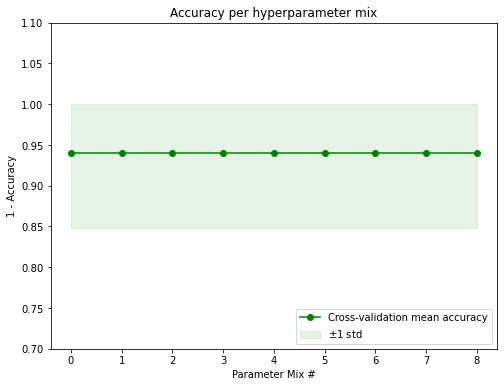

In [8]:
#Plots results

# Declares the end plot size
fig = plt.figure(figsize=(8,6))

# Plots the mean of the CV Accuracy
plt.plot(n_items, 
         Mean_Acc, 
         'o-', 
         color="g",
         label="Cross-validation mean accuracy")

# Plots the std of the CV Accuracy
plt.fill_between(n_items, 
                 Mean_Acc - Std_Acc,
                 1, #Accuracy cannot go above 1
                 alpha=0.1, 
                 color="g", 
                 label = '$\pm 1$ std')

# Prints plot
plt.ylim(0.7,1.1)
plt.ylabel('1 - Accuracy')
plt.xlabel('Parameter Mix #')

plt.legend(loc="lower right")
plt.title('Accuracy per hyperparameter mix')

plt.show()

We see that for all parameter mixes, we obtain similar accuracies. As such, we would prefer the mix with the least amount of computational complexity.

<hr>

## Part 1 - Exercise 2

**Use the previous 10-fold cross-validation to plot and compute the average area under the curve of the LDA classifier. You can use the built in method *predict_proba(X)*.**

In [9]:
# Global variable declaration

roc_sample = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)

i = 0
n_repeats = 3

In [10]:
# Model declaration

model = LinearDiscriminantAnalysis()

We want to check whether we may be facing the case of an unbalanced dataset when performing a train-test split. In such a case, k-fold cross-validation may be problematic and lead to a biased prediction and accuracy.

In [11]:
# Testing consistent split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

print("*** Training ***")
print("Elements of class 0: " + str(np.sum(y_train==0)/len(y_train)))
print("Elements of class 1: " + str(np.sum(y_train==1)/len(y_train)))

print("\n*** Testing ***")
print("Elements of class 0: " + str(np.sum(y_test==0)/len(y_test)))
print("Elements of class 1: " + str(np.sum(y_test==1)/len(y_test)))

print("\n*** Training + Testing ***")
print("Elements of class 0: " + str(np.sum(y==0)/len(y)))
print("Elements of class 1: " + str(np.sum(y==1)/len(y)))

*** Training ***
Elements of class 0: 0.52
Elements of class 1: 0.48

*** Testing ***
Elements of class 0: 0.48
Elements of class 1: 0.52

*** Training + Testing ***
Elements of class 0: 0.5
Elements of class 1: 0.5


Of note:

> The classes are not per se equally represented in in the dataset, 0.52 vs 0.48 in the training set, and the reverse in the testing set. However, since we know that we are using the ``weight=[0.5]`` parameter in making our dataset (via the ``make_classification`` function), we know that our distribution is supposedly balanced. 
> 
> In other cases, we would have to consider our dataset as imbalanced. 
>
> Imbalance would in all likelihood carry over to Training and Testing splits. This would be a problem in the evaluation of our LDA model as the performance is not evaluated on data with the same distribution. In such a situation, we would have liked to keep the proportion of classes constant across data splits. A process that can be used to answer this issue would be ``stratified k-fold``.

However, based on the knowledge that our dataset is generated in a balanced fashion, we will use ``repeated k-fold`` for this exercise, rather than use ``stratified k-fold``.

As such, we devise a strategy where we perform a Repeated K-Fold with ``folds`` (10) folds and ``n_repeats`` (2) repeats.

In [12]:
# RepeatedKFold strategy object declaration

cv = RepeatedKFold(n_splits=folds, n_repeats=2, random_state=0)

Test Accuracy Scores for each fold using the Repeated K-Fold method:

Fold 1 Test Accuracy: 0.90, Precision: 1.00, Recall: 0.86, F1 score: 0.92
Fold 2 Test Accuracy: 0.90, Precision: 1.00, Recall: 0.86, F1 score: 0.92
Fold 3 Test Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 score: 1.00
Fold 4 Test Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 score: 1.00
Fold 5 Test Accuracy: 0.80, Precision: 1.00, Recall: 0.60, F1 score: 0.75
Fold 6 Test Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 score: 1.00
Fold 7 Test Accuracy: 0.90, Precision: 1.00, Recall: 0.75, F1 score: 0.86
Fold 8 Test Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 score: 1.00
Fold 9 Test Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 score: 1.00
Fold 10 Test Accuracy: 0.90, Precision: 1.00, Recall: 0.80, F1 score: 0.89
Fold 11 Test Accuracy: 0.90, Precision: 1.00, Recall: 0.67, F1 score: 0.80
Fold 12 Test Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 score: 1.00
Fold 13 Test Accuracy: 0.90, Precision:

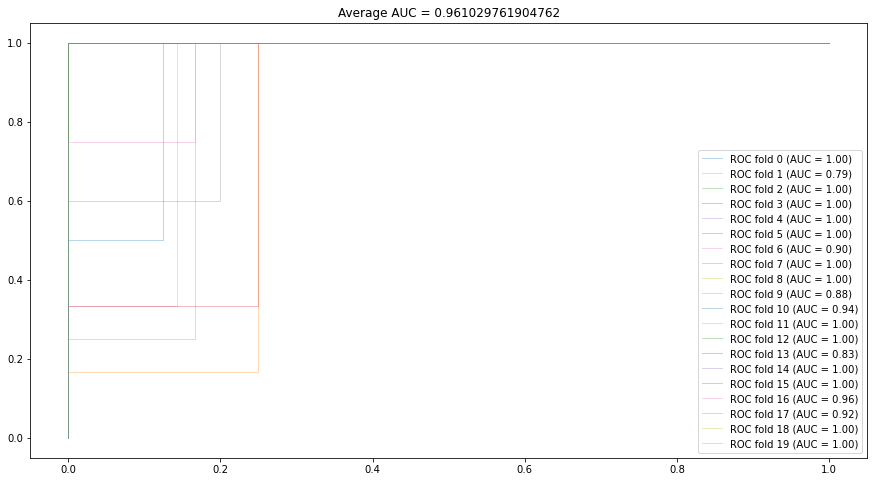

In [13]:
# Cross-validation loop: runs LDA with Repeated K-Fold Cross Validation and plot ROC curves

# Declares the end plot size
fig = plt.figure(figsize=(15,8))

# Prints title line
print("Test Accuracy Scores for each fold using the Repeated K-Fold method:\n")

# Declares loop
for train, test in cv.split(X, y):
    
    # Computes the predictions
    predictions = model.fit(X[train], y[train]).predict_proba(X[test])
    
    # Computes the ROC and AUC data
    fpr, tpr, thresholds = roc_curve(y[test], predictions[:, 1])
    roc_sample.append(np.interp(mean_fpr, fpr, tpr))
    # ROC curve is set to start at 0
    roc_sample[-1][0] = 0.0
    # Computes the AUC
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # Plots the AUC
    plt.plot(fpr, tpr, 
             lw=1, alpha=0.3,
             label=f"ROC fold {i} (AUC = {roc_auc:.2f})")
    
    # Prints the Accuracy, Precision, Recall, F1 scores
    acc = accuracy_score(model.predict(X[test]), y[test])
    P = precision_score(model.predict(X[test]), y[test])
    R = recall_score(model.predict(X[test]), y[test])
    f1 = 2*P*R/(P+R)
    print(f"Fold {i+1} Test Accuracy: {acc:.2f}, Precision: {P:.2f}, " + 
          f"Recall: {R:.2f}, F1 score: {f1:.2f}")
    
    # Increments
    i+= 1

# Prints the plot
print("\nAUC plot:")
plt.legend()
plt.title("Average AUC = " + str(np.mean(aucs)))
plt.show()

AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions. [[source](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)]

<u>Observation:</u>

As such, we see that we obtained a very high average area under the curve (c. 0.96), indicating that our binary classifier (our LDA model) has a strong predictive power on the current dataset.

<hr>

We summarize the cross-validation results using a Receiving Operator Characteristic (ROC) curve.

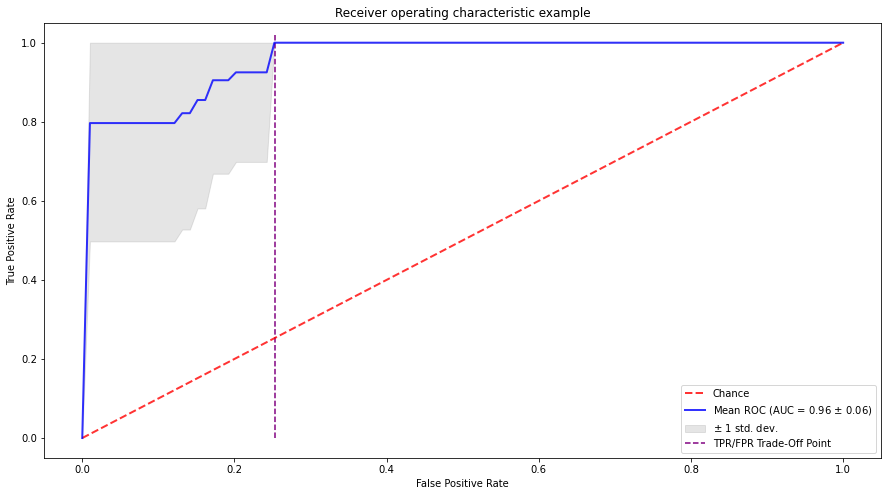

In [14]:
# Summarizes the cross-validation results

# Declares the end plot size
fig = plt.figure(figsize=(15,8))

# Adds diagonal line of random classification to the plot
plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         lw=2, 
         color='r',
         label='Chance', 
         alpha=.8)

# Computes mean and std for the curves
mean_tpr = np.mean(roc_sample, axis=0)
std_tpr = np.std(roc_sample, axis=0)

# Sets the end point of the average ROC to be equal to 1
mean_tpr[-1] = 1.0

# Computes the AUC of the average curves
mean_auc = auc(mean_fpr, mean_tpr)

# Computes the std of the AUCs 
std_auc = np.std(aucs)

# Plots the ROC curve
plt.plot(mean_fpr, 
         mean_tpr, 
         color='b',
         label=f"Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})",
         lw=2, 
         alpha=.8)

# Plots the std of the ROC curve
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, 
                 tprs_lower, 
                 tprs_upper, 
                 color='grey', 
                 alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

# Plots vertical line
plt.vlines(x = 0.253, ymin = 0, ymax = 1.02,
           colors = 'purple',
           label = 'TPR/FPR Trade-Off Point',
           linestyles='dashed')

# Prints the Plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

A Receiver Operator Characteristic (ROC) curve is a graphical plot used to show the diagnostic ability of binary classifiers. A ROC curve is constructed by plotting the true positive rate (TPR) against the false positive rate (FPR). The true positive rate is the proportion of observations that were correctly predicted to be positive out of all positive observations (TP/(TP + FN)). Similarly, the false positive rate is the proportion of observations that are incorrectly predicted to be positive out of all negative observations (FP/(TN + FP)).

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test. [[source](https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/)]

<u>Observation:</u>

We see that we can expect our binary classifier (our LDA model) to achieve a True Positive Rate of 1 with, at a minimum, a trade-off of a False Positive Rate of c. 0.25 (when ideally it would be 0). If we were to be in the case where we have to pay close attention to the FPR, we could reduce our expected TPR to around 0.8 and expect in return a much lower (i.e. near 0) FPR as a trade-off.

<hr>

## Part 1 - Exercise 3

**Define the appropriate cross-validation strategy and measurement of the area under the curve for the data:**

In [15]:
# Global variable declaration

n_samples = 200
n_features = 5
i=0

means = [] 
stdevs = []

fold_range = np.array(list(range(2,
                                 min(np.sum(y == 0), 
                                     np.sum(y == 1)))))

roc_sample = [[],[]]
aucs = [[],[]]
mean_fpr = np.linspace(0, 1, n_samples)

In [16]:
# Dataset generation

X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features, 
                           n_redundant=0, 
                           n_informative=3,
                           random_state=0, 
                           n_clusters_per_class=1, 
                           weights = [0.9])

In [17]:
# Model declaration

model = LinearDiscriminantAnalysis()

We want to check whether we may be facing the case of an unbalanced dataset when performing a train-test split. In such a case, k-fold cross-validation may be problematic and lead to a biased prediction and accuracy.

In [18]:
# Testing consistent split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("*** Training ***")
print("Elements of class 0: " + str(np.sum(y_train==0)/len(y_train)))
print("Elements of class 1: " + str(np.sum(y_train==1)/len(y_train)))

print("\n*** Testing ***")
print("Elements of class 0: " + str(np.sum(y_test==0)/len(y_test)))
print("Elements of class 1: " + str(np.sum(y_test==1)/len(y_test)))

print("\n*** Training + Testing ***")
print("Elements of class 0: " + str(np.sum(y==0)/len(y)))
print("Elements of class 1: " + str(np.sum(y==1)/len(y)))

*** Training ***
Elements of class 0: 0.9125
Elements of class 1: 0.0875

*** Testing ***
Elements of class 0: 0.875
Elements of class 1: 0.125

*** Training + Testing ***
Elements of class 0: 0.905
Elements of class 1: 0.095


The classes are not equally represented in in the dataset, 0.9125 vs 0.0875 in the training set and 0.875 and 0.125 in the testing set. As such, we can assert that our distribution is not balanced. 

An imbalanced distribution will likely carry over to any Training or Testing splits. This raises a problem in the evaluation of our LDA model as the performance is not evaluated on data with the same distribution. In such a situation, we need to keep the proportion of classes constant across all possible data splits. In this case, a process that can be used is called ``stratified k-fold``.

We devise a strategy where we perform a Stratified K-Fold over a range ``fold_range`` of folds. 

In [19]:
# Testing consistent split with StratKFold

skf = StratifiedKFold(n_splits=folds)

for idx, (train, test) in enumerate(skf.split(X, y)):
    print(f"\n##### Example with fold-mix #{idx} #####")
    print("\n*** Training ***")
    print("Elements of class 0: " + str(np.sum(y[train]==0)/len(y[train])))
    print("Elements of class 1: " + str(np.sum(y[train]==1)/len(y[train])))
    print("*** Testing ***")
    print("Elements of class 0: " + str(np.sum(y[test]==0)/len(y[test])))
    print("Elements of class 1: " + str(np.sum(y[test]==1)/len(y[test])))


##### Example with fold-mix #0 #####

*** Training ***
Elements of class 0: 0.9
Elements of class 1: 0.1
*** Testing ***
Elements of class 0: 0.95
Elements of class 1: 0.05

##### Example with fold-mix #1 #####

*** Training ***
Elements of class 0: 0.9055555555555556
Elements of class 1: 0.09444444444444444
*** Testing ***
Elements of class 0: 0.9
Elements of class 1: 0.1

##### Example with fold-mix #2 #####

*** Training ***
Elements of class 0: 0.9055555555555556
Elements of class 1: 0.09444444444444444
*** Testing ***
Elements of class 0: 0.9
Elements of class 1: 0.1

##### Example with fold-mix #3 #####

*** Training ***
Elements of class 0: 0.9055555555555556
Elements of class 1: 0.09444444444444444
*** Testing ***
Elements of class 0: 0.9
Elements of class 1: 0.1

##### Example with fold-mix #4 #####

*** Training ***
Elements of class 0: 0.9055555555555556
Elements of class 1: 0.09444444444444444
*** Testing ***
Elements of class 0: 0.9
Elements of class 1: 0.1

##### Example

Given this observation, we need to devise a k-fold cross validation strategy that can perform on such an unbalanced dataset (along with its potentially unbalanced splits).

- **Step 1**: Looking for the best number of folds

- **Step 2**: Computing AUC

- **Step 3**: Computing ROC

### Step 1 - Finding K

We decide to perform our stratified k-fold cross validation over a range of possible k values and select the one(s) with the highest accuracies, or in case of similar accuracies, the one(s) with the lowest standard deviation.

In [20]:
# Cross-validation loop: runs LDA with Stratified (K)-Fold Cross Validation to find best K(s)

# Prints title lines
print("##### Mean test accuracies per fold #####")
print("### (with Stratified K-Fold strategy) ###\n")

# Declares loop
for k in fold_range:
    
    # Model declaration
    model = LinearDiscriminantAnalysis()
    
    # Resets list at start of loop
    accuracies_within_fold = []
    
    # Declares the stratified folding
    skf = StratifiedKFold(n_splits=k)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #Fit model on X_train
        model.fit(X_train,y_train)

        #Store each Kfold accuracy values on X_test
        accuracies_within_fold.append(accuracy_score(y_test, model.predict(X_test)))
    
    print(f"{k}-fold cross-validation score: {np.mean(accuracies_within_fold):.2f}")
    
    #Average and std for a particular k fold
    means.append(np.mean(accuracies_within_fold))
    stdevs.append(np.sqrt(np.var(accuracies_within_fold, ddof = 1)))


# Formats
means  = np.asarray(means)
stdevs  = np.asarray(stdevs)

##### Mean test accuracies per fold #####
### (with Stratified K-Fold strategy) ###

2-fold cross-validation score: 0.97
3-fold cross-validation score: 0.97
4-fold cross-validation score: 0.97
5-fold cross-validation score: 0.97
6-fold cross-validation score: 0.97
7-fold cross-validation score: 0.97
8-fold cross-validation score: 0.97
9-fold cross-validation score: 0.97
10-fold cross-validation score: 0.97
11-fold cross-validation score: 0.97
12-fold cross-validation score: 0.97
13-fold cross-validation score: 0.97
14-fold cross-validation score: 0.97
15-fold cross-validation score: 0.97
16-fold cross-validation score: 0.97
17-fold cross-validation score: 0.97
18-fold cross-validation score: 0.97
19-fold cross-validation score: 0.97
20-fold cross-validation score: 0.97
21-fold cross-validation score: 0.97
22-fold cross-validation score: 0.97
23-fold cross-validation score: 0.97
24-fold cross-validation score: 0.97
25-fold cross-validation score: 0.97
26-fold cross-validation score: 0.9

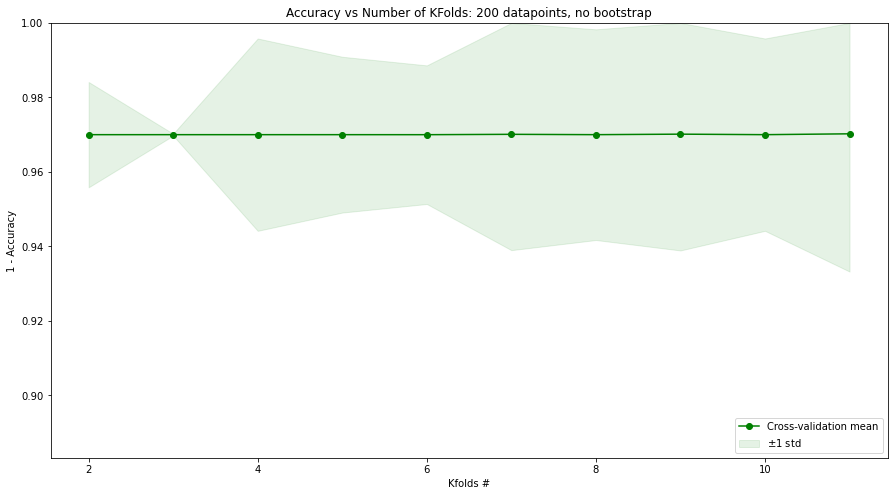

In [21]:
#Plots results for the first 20 folds

# Declares the end plot size
fig = plt.figure(figsize=(15,8))

# Plots the mean of the CV Accuracy
plt.plot(fold_range[:10], 
         means[:10], 
         'o-', 
         color="g",
         label="Cross-validation mean")

# Plots the std of the CV Accuracy
plt.fill_between(fold_range[:10], 
                 means[:10] - stdevs[:10],
                 np.array(list(map(lambda x: 1 if x>1 else x,
                                   means[:10] + stdevs[:10]))), #Accuracy cannot go above 1
                 alpha=0.1, 
                 color="g", 
                 label = '$\pm 1$ std')

# Prints plot
plt.ylim(min(means[:10] - stdevs[:10])-0.05,1)
plt.ylabel('1 - Accuracy')
plt.xlabel('Kfolds #')

plt.legend(loc="lower right")
plt.title('Accuracy vs Number of KFolds: 200 datapoints, no bootstrap')

plt.show()

Given that we yielded similar accuracies, we choose to study the AUC produced by a Stratified K-Fold method in two distinct cases: 3 folds and 6 folds. Our choice is driven by the fact that those two cases yielded the lowest standard deviations besides the 2-fold case (which is equivalent to a common Train-Test split, and thus was discarded).

### Step 2 - Computing AUC

In [22]:
# Model declaration

model = LinearDiscriminantAnalysis()

Test Accuracy Scores for each fold using the StratifiedKFold method:


Test Accuracy Scores with the StratifiedKFold method using 3 folds:

Fold 1 Test Accuracy: 0.97, Precision: 0.67, Recall: 1.00, F1 score: 0.80
Fold 2 Test Accuracy: 0.97, Precision: 0.71, Recall: 1.00, F1 score: 0.83
Fold 3 Test Accuracy: 0.97, Precision: 0.67, Recall: 1.00, F1 score: 0.80

Test Accuracy Scores with the StratifiedKFold method using 6 folds:

Fold 1 Test Accuracy: 0.94, Precision: 0.33, Recall: 1.00, F1 score: 0.50
Fold 2 Test Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 score: 1.00
Fold 3 Test Accuracy: 0.97, Precision: 0.67, Recall: 1.00, F1 score: 0.80
Fold 4 Test Accuracy: 0.97, Precision: 0.67, Recall: 1.00, F1 score: 0.80
Fold 5 Test Accuracy: 0.97, Precision: 0.67, Recall: 1.00, F1 score: 0.80
Fold 6 Test Accuracy: 0.97, Precision: 0.67, Recall: 1.00, F1 score: 0.80

AUC plot:


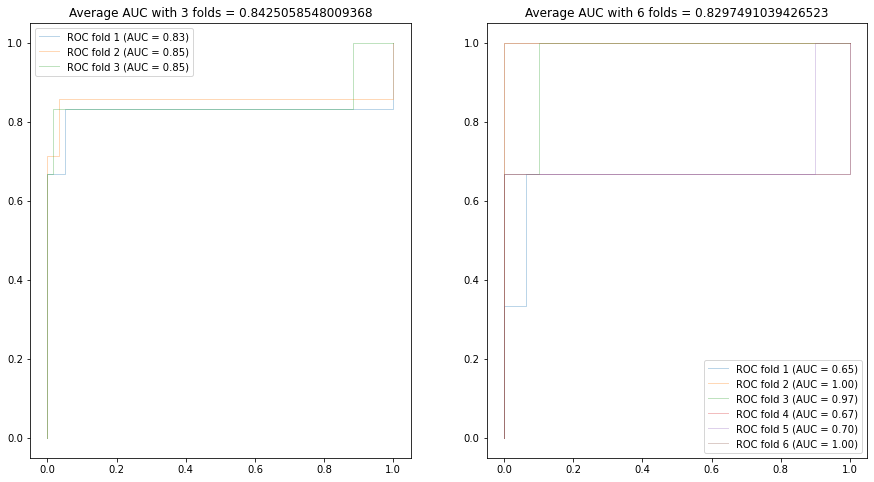

In [23]:
# Cross-validation loop: runs LDA with Stratified (K)-Fold Cross Validation to find best K(s)

# Prints title line
print("Test Accuracy Scores for each fold using the StratifiedKFold method:\n")

# Declares the end plot size 
fig = plt.figure(figsize=(15,8))

# Declares loop over folds
for idx, fold in enumerate([3, 6]):
    print(f"\nTest Accuracy Scores with the StratifiedKFold method using {fold} folds:\n")
    # Declares StratifiedKFold strategy
    cv = StratifiedKFold(n_splits=fold)
    i=0
    # Cross-validation loop: runs LDA with cross-validation and plot ROC curves
    for train, test in cv.split(X, y):
        
        # Computes the predictions
        predictions = model.fit(X[train], y[train]).predict_proba(X[test])
        
        # Compute the ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y[test], predictions[:, 1])
        roc_sample[idx].append(np.interp(mean_fpr, fpr, tpr))
        # ROC curve is set to start at 0
        roc_sample[idx][-1][0] = 0.0
        # Computes the AUC
        roc_auc = auc(fpr, tpr)
        aucs[idx].append(roc_auc)
        
        # Plots the AUC
        plt.subplot(1,2,idx+1)
        plt.plot(fpr, tpr, 
                 lw=1, alpha=0.3,
                 label=f"ROC fold {i+1} (AUC = {roc_auc:.2f})")
        plt.legend()
        plt.title(f"Average AUC with {fold} folds = {np.mean(aucs[idx])}")
        
        # Prints the Accuracy score
        acc = accuracy_score(model.predict(X[test]), y[test])
        P = precision_score(model.predict(X[test]), y[test])
        R = recall_score(model.predict(X[test]), y[test])
        f1 = 2*P*R/(P+R)
        print(f"Fold {i+1} Test Accuracy: {acc:.2f}, Precision: {P:.2f}, " + 
          f"Recall: {R:.2f}, F1 score: {f1:.2f}")
        
        # Increments
        i += 1

# Prints the plot
print("\nAUC plot:")
plt.legend()
plt.show()

<u>Observation:</u>

We see that we obtain a high average area under the curve (c. 0.8 for our model (LDA) in the context of two cross-validation processes), albeit in a lower fashion that the results we obtained in exercise 2. This is expected as our dataset is more complex (i.e. more features [5 vs. 2] and a strong imbalance [0.9 vs. 0.5]).

Still, at first glance, we can say that both models seem to have a strong predictive power on the current dataset although the 6-fold stratified k-fold process seems to have yielded a higher variance in terms of results.

### Step 3 - Computing ROC

We summarize the cross-validation results using a Receiving Operator Characteristic (ROC) curve.

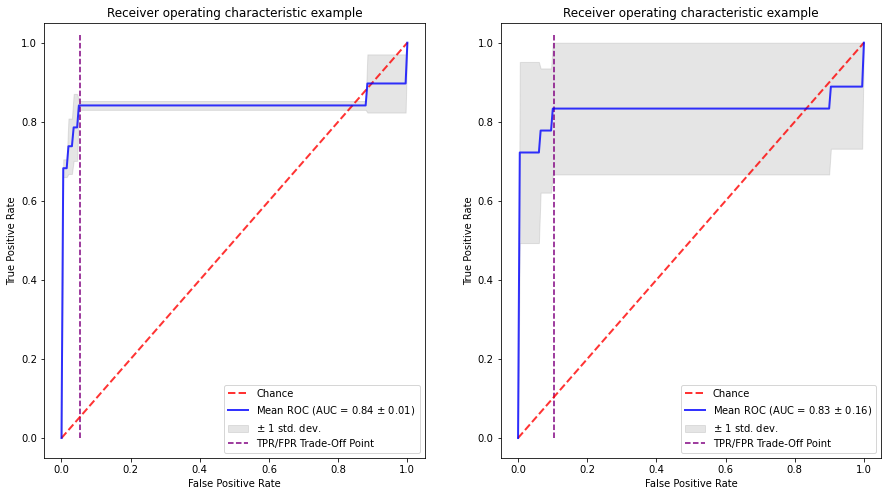

In [24]:
# Summarizes the cross-validation results

# Declares the end plot size
fig = plt.figure(figsize=(15,8))

for idx in [0, 1]:
    
    # Adds diagonal line of random classification 
    plt.subplot(1,2,idx+1)
    plt.plot([0, 1], 
             [0, 1], 
             linestyle='--', 
             lw=2, 
             color='r',
             label='Chance', 
             alpha=.8)

    # Computes mean and std for the curves
    mean_tpr = np.mean(roc_sample[idx], axis=0)
    std_tpr = np.std(roc_sample[idx], axis=0)

    # Sets the end point of the average ROC to be equal to 1
    mean_tpr[-1] = 1.0

    # Computes the AUC of the average curves
    mean_auc = auc(mean_fpr, mean_tpr)
    
    # Computes the std of the AUCs 
    std_auc = np.std(aucs[idx])
    
    # Plots the ROC curve
    plt.plot(mean_fpr, 
             mean_tpr, 
             color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, 
             alpha=.8)


    # Plots the std
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Plots vertical line
    plt.vlines(x = 0.053+(idx*5)/100, ymin = 0, ymax = 1.02,
           colors = 'purple',
           label = 'TPR/FPR Trade-Off Point',
           linestyles='dashed')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

# Prints the Plot

plt.show()

<u>Observation:</u>

A first observation is that we see a well-performing binary classifier (our LDA model) in terms of TPR-FPR trade off. The 3-fold and 6-fold strategies have a trade-off point around a 80%+ TPR:

- Our 3-fold stratified k-fold strategy achieves a True Positive Rate of c. 0.85 with, at a minimum, a trade-off of a False Positive Rate of c. 0.05 (when ideally it would be 0).

- Our 6-fold stratified k-fold strategy achieves a True Positive Rate of c. 0.85 with, at a minimum, a trade-off of a False Positive Rate of c. 0.1 (when ideally it would be 0).

A second observation is that the 6-fold strategy shows a much higher variance compared to the 3-fold strategy. 

A third observation is that, once 80%+ TPR is reached, the trade-off with FPR drops dramatically, even going lower than the 45-degree diagonal (indicative of chance). Since the FPR explodes after this tipping point, we can emit the hypothesis that the model (LDA in our case) is overfitting one class over the other (likely the one over-represented in our distribution). 

This seems to indicate that our model hits a limit in performance that might be solved either by hyperparameter tuning, or by swapping for another class of classifiers. Such class may be able to display and predict more accurately than LDA in the presence of more complex features, and more imbalanced classes.

# Assignments 3 - Part 2

**During lesson we discussed the problem of _selection bias_ in cross-validation. 
This problem is nicely investigated in the paper *On the Dangers of Cross-Validation. An Experimental Evaluation*, accessible here:**

http://people.csail.mit.edu/romer/papers/CrossVal_SDM08.pdf


**Read**
- Section 1 (Introduction), 
- Section 4 (Experiments on Synthetic Data), 
- Section 7 (Discussion)

**And write a short summary (~half a page) about these three sections (results and take home message).**



<hr>

**word count**: 300

<u>Summary:</u>

A classifier must learn generalized features from a dataset, then perform accurate predictions on yet unseen data. Procuring this test data is often problematic. As such, statisticians developed resampling methods on training data to increase model robustness. One such method is cross-validation (CV): a model is trained on a subset of the available dataset, then validated on the rest. This approach is an industry mainstay as it is considered a reliable model comparator. Or so it is thought. CV can dramatically overfit, and thus fail at model comparison. The paper wants to provide an exhaustive demonstration of this shortfall.
 
A Leave-One-Out (LOO) CV is used to train and predict $M$ algorithms over a synthetic dataset with a $\frac{1}{2}$ true error. An accuracy score, average of three LOOCV iterations, is used. It is found that as $M$ increases, accuracy increases too (from $61.9$ with $M=10$, to $85.6$ with $M=1000000$), diverging from the true error, $\frac{1}{2}$. This overfitting behavior is also observed when increasing sample size, data dimensionality, model complexity, and the amount of selected features. LOOCV leads to selecting algorithms that overestimate the true accuracy the most.
 
The paper ends up demonstrating a known but not-yet properly tested phenomenon: CV may become ineffective. It can fail in a diversity of cases as the process may impact negatively a model’s generalization error, running the risk of higher variance, overfitting, and thus unreliability. To remedy this behavior, the paper offers to use a “sequestered” test set to be used once training and validation are completed. The error on the validation and test sets would be checked to see whether they are close. The paper finally cautions to not perform selection based on the test set as it breaks the hypothesis of testing in a “real-world setting."